In [ ]:
w_python = !which python
if 'home' in w_python[0]:
    resources_prefix = ''
else:
    !pip install watermark

    from google.colab import drive
    drive.mount('/content/drive')

    resources_prefix = '/content/drive/MyDrive/Machine Learning/Notebooks/0201_Classification - Iris Dataset Analysis/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
# !conda install -y watermark

In [ ]:
%load_ext watermark
%watermark

Last updated: 2022-08-03T22:18:01.892224+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [ ]:
import pandas as pd

import numpy as np

import seaborn as sns

from IPython.display import Image

from ipywidgets import fixed, interact

import graphviz

import pickle

import os

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.python.platform import build_info as build
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import Adam

import keras
from keras.models import Sequential, load_model
from keras.layers import BatchNormalization, Dense, Input, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.constraints import maxnorm

from scipy import stats

from IPython.display import display

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, RandomForestClassifier, BaggingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Resume

https://www.kaggle.com/datasets/uciml/iris

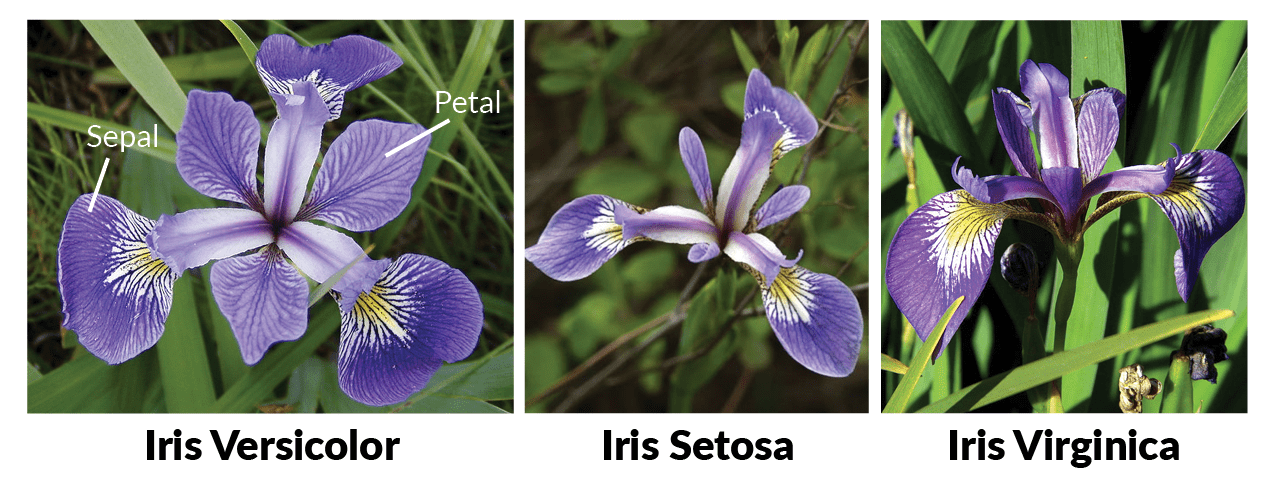

## Data Collection

In [ ]:
sns.set_style("whitegrid")

In [ ]:
iris = load_iris()
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['target'])

# Rename the columns
df.rename(columns={"sepal length (cm)": "SEPAL_LENGHT",
                   "sepal width (cm)": "SEPAL_WIDTH",
                   "petal length (cm)": "PETAL_LENGHT",
                   "petal width (cm)": "PETAL_WIDTH",
                   "target": "TARGET"}, inplace=True)

df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


## Data Wrangling

If multiple data sources are combined in the same dataset, the indexes must be reset.

In [ ]:
df[df.index.duplicated()].count()

SEPAL_LENGHT    0
SEPAL_WIDTH     0
PETAL_LENGHT    0
PETAL_WIDTH     0
TARGET          0
dtype: int64

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df[df.index.duplicated()].count()

SEPAL_LENGHT    0
SEPAL_WIDTH     0
PETAL_LENGHT    0
PETAL_WIDTH     0
TARGET          0
dtype: int64

Data types are analyzed and corrected.

In [ ]:
df.dtypes

SEPAL_LENGHT    float64
SEPAL_WIDTH     float64
PETAL_LENGHT    float64
PETAL_WIDTH     float64
TARGET          float64
dtype: object

Dependent column.

In [ ]:
target_column = 'TARGET'

For best model performance, dependent classes should start at 0 and not 1.

In [ ]:
df[target_column].unique()

array([0., 1., 2.])

The following function should be called whenever a column is added to or removed from the dataset.

In [ ]:
def update_datatypes_columns():
    numeric_columns = df.select_dtypes(include=np.number).columns
    continuous_columns = df.select_dtypes(include=np.float64).columns
    discrete_columns = df.select_dtypes(include=np.int64).columns
    categorical_columns = df.select_dtypes(include='category').columns
    object_columns = df.select_dtypes(include='object').columns

    return numeric_columns, continuous_columns, discrete_columns, categorical_columns, object_columns


numeric_columns, continuous_columns, discrete_columns, categorical_columns, object_columns = update_datatypes_columns()

## Data Cleaning

### Duplicate Records

The records that are identical in all their columns are verified.

In [ ]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
145    False
146    False
147    False
148    False
149    False
Length: 150, dtype: bool

In [ ]:
duplicated = df[df.duplicated()].shape  # Cuántos records están duplicados
duplicated

(1, 5)

View duplicate records.

In [ ]:
df[df.duplicated(keep=False)]

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
101,5.8,2.7,5.1,1.9,2.0
142,5.8,2.7,5.1,1.9,2.0


In [ ]:
if duplicated[0] > 0:
    print('There are duplicate records.')
else:
    print('There are no duplicate records.')

There are duplicate records.


We use the pandas `drop_duplicates` function to remove duplicate records.

In [ ]:
df = df.drop_duplicates(keep='first')
df.shape

(149, 5)

### Cardinality

If a column has the same value always (> 90%), that column can be deleted.

In [ ]:
n_records = len(df)


def duplicate_column_values(df):
    resume = pd.DataFrame(columns=['VARIABLE', 'LESS_COMMON', '% LESS_COMMON', 'MORE_COMMON', '% MORE_COMMON', 'DATA_TYPE'])

    for columna in df:
        n_per_value = df[columna].value_counts()
        more_common = n_per_value.iloc[0]
        less_common = n_per_value.iloc[-1]

        new_df = pd.DataFrame(data={'VARIABLE': [columna],
                                    'LESS_COMMON': [less_common],
                                    '% LESS_COMMON': [round(less_common * 100 / (1.0 * n_records), 3)],
                                    'MORE_COMMON': [more_common],
                                    '% MORE_COMMON': [round(more_common * 100 / (1.0 * n_records), 3)],
                                    'DATA_TYPE': [df[columna].dtype]})

        resume = pd.concat([resume, new_df], ignore_index=True)

    return resume


resume = duplicate_column_values(df)
resume

,VARIABLE,LESS_COMMON,% LESS_COMMON,MORE_COMMON,% MORE_COMMON,DATA_TYPE
0,SEPAL_LENGHT,1,0.671,10,6.711,float64
1,SEPAL_WIDTH,1,0.671,26,17.450,float64
2,PETAL_LENGHT,1,0.671,13,8.725,float64
3,PETAL_WIDTH,1,0.671,29,19.463,float64
4,TARGET,49,32.886,50,33.557,float64


In [ ]:
resume = resume.loc[resume['% MORE_COMMON'] > 90.]
resume

,VARIABLE,LESS_COMMON,% LESS_COMMON,MORE_COMMON,% MORE_COMMON,DATA_TYPE


In [ ]:
if resume.loc[resume['% MORE_COMMON'] > 90.].size == 0:
    print('No field contains more than 90% of its data repeated.')
else:
    print('Some fields contain more than 90% of their data repeated. They must be removed.')

No field contains more than 90% of its data repeated.


The analysis is performed to eliminate or not the columns.

The columns will be removed.

In [ ]:
df.drop(resume.VARIABLE, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Missing Values

Completely empty columns are removed.

In [ ]:
df.dropna(axis=1, how='all', inplace=True)

Completely empty rows are removed.

In [ ]:
df.dropna(axis=0, how='all', inplace=True)

# In case you want to delete the row if any of its values is missing, use 'any' in the 'how' parameter
# Use subset['col1', 'col2'] if you want to apply to some columns only.

#### Continuous Variables

Continuous variables are selected.

In [ ]:
continuous_data = df[continuous_columns]
continuous_data.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [ ]:
# Casos con variables null
if continuous_data[continuous_data.isnull().any(axis=1)].shape[0] > 0:
    print('There are continuous variables with null value.')
else:
    print('There are no continuous variables with a null value.')

There are no continuous variables with a null value.


In [ ]:
# Shows cases with null variables.
continuous_data[continuous_data.isnull().any(axis=1)]

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET


In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')   # The mean is used

continuous_data_imp = imputer.fit_transform(continuous_data)
continuous_data_imp.shape   # Stores all values, not just imputed ones

(149, 5)

In [ ]:
# Convert to a dataframe
continuous_data_imp = pd.DataFrame(data=continuous_data_imp, index=continuous_data.index, columns=continuous_data.columns)

# Preserve datatypes
continuous_data_imp = continuous_data_imp.astype(continuous_data.dtypes.to_dict())

continuous_data_imp.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


It verifies that there are no null values.

In [ ]:
continuous_data_imp[continuous_data_imp.isnull().any(axis=1)].shape

(0, 5)

The original dataset is updated with the imputed values.

In [ ]:
df.loc[:, continuous_data.columns] = continuous_data_imp
df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


#### Discrete - Categorical Variables

Discrete or categorical variables are selected.

In [ ]:
discrete_categorical_data = df[discrete_columns.union(categorical_columns)]
discrete_categorical_data.head()

""
0
1
2
3
4


In [ ]:
# Cases with null variables
if discrete_categorical_data[discrete_categorical_data.isnull().any(axis=1)].shape[0] > 0:
    print('There are discrete or categorical variables with a null value.')
else:
    print('There are no discrete or categorical variables with a null value.')

There are no discrete or categorical variables with a null value.


In [ ]:
# Show cases with null variables
discrete_categorical_data[discrete_categorical_data.isnull().any(axis=1)]

""


In [ ]:
if discrete_categorical_data.columns.size > 0:
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')   # most_frequent is used

    discrete_categorical_imp = imputer.fit_transform(discrete_categorical_data)
    # Stores all values, not just imputed ones.
    print(discrete_categorical_imp.shape)
else:
    print('There are no discrete or categorical variables.')

There are no discrete or categorical variables.


In [ ]:
if discrete_categorical_data.columns.size > 0:
    # Convert to a dataframe.
    discrete_categorical_imp = pd.DataFrame(data=discrete_categorical_imp, index=discrete_categorical_data.index, columns=discrete_categorical_data.columns)
    
    # Preserve datatypes
    discrete_categorical_imp = discrete_categorical_imp.astype(discrete_categorical_data.dtypes.to_dict())

    display(discrete_categorical_imp.head())
else:
    print('There are no discrete or categorical variables.')

There are no discrete or categorical variables.


It verifies that there are no null values.

In [ ]:
if discrete_categorical_data.columns.size > 0:
    print(discrete_categorical_imp[discrete_categorical_imp.isnull().any(axis=1)].shape)
else:
    print('There are no discrete or categorical variables.')

There are no discrete or categorical variables.


The original dataset is updated with the imputed values.

In [ ]:
if discrete_categorical_data.columns.size > 0:
    df.loc[:, discrete_categorical_data.columns] = discrete_categorical_imp
    display(df.head())
else:
    print('There are no discrete or categorical variables.')

There are no discrete or categorical variables.


#### Outliers

It applies to both independent and dependent numerical variables.

In [ ]:
def outliers_col(df):
    resume = pd.DataFrame(columns=['VARIABLE', 'FREQUENCY', 'OUTLIER', 'DATA_TYPE'])

    for col in df.select_dtypes(exclude=[object, 'category', 'datetime64[ns]']).drop([], axis=1):
        # zcores absoluto de cada valor de la columna seleccionada
        zcores = np.abs(stats.zscore(df[col]))

        # TODO: Probar con 1.5 luego, así funcionan los boxplots
        n_outliers = len(df[zcores > 3])

        new_df = pd.DataFrame(data={'VARIABLE': [col],
                                    'FREQUENCY': [n_outliers],
                                    'OUTLIER': [False if n_outliers == 0 else True],
                                    'DATA_TYPE': [df[col].dtype]})

        resume = pd.concat([resume, new_df], ignore_index=True)

    return resume


resume = outliers_col(df)
resume

,VARIABLE,FREQUENCY,OUTLIER,DATA_TYPE
0,SEPAL_LENGHT,0,False,float64
1,SEPAL_WIDTH,1,True,float64
2,PETAL_LENGHT,0,False,float64
3,PETAL_WIDTH,0,False,float64
4,TARGET,0,False,float64


In [ ]:
if resume.FREQUENCY.where(resume.FREQUENCY > 0).count() == 0:
    print('There are no outliers.')
else:
    print('There are some outliers. We can do a boxplot to visualize the outliers better.')

There are some outliers. We can do a boxplot to visualize the outliers better.


Outliers are removed until none remain.

When there are many numerical variables, the elimination of outliers causes other outliers in other columns and the size of the dataset can be greatly reduced with the iterative process.

In [ ]:
while resume.FREQUENCY.where(resume.FREQUENCY > 0).count() > 0:
    for col in resume.VARIABLE:
        before_len = df.shape[0]
        df = df[np.abs(stats.zscore(df[col])) < 3]
        after_len = df.shape[0]

        print('0, ' if before_len == df.shape[0] else f'-{before_len - df.shape[0]}, ', end='')

    resume = outliers_col(df)

0, -1, 0, 0, 0, 

## Data Visualization

### Statistical Summary

In [ ]:
df.describe()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
count,148.000000,148.000000,148.000000,148.000000,148.000000
mean,5.844595,3.050676,3.764189,1.200000,1.000000
std,0.833588,0.423541,1.764002,0.762381,0.816497
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.200000,6.900000,2.500000,2.000000


### Correlation

#### Dispersion Diagram

In [ ]:
@interact(df=fixed(df.copy()), x=numeric_columns, y=np.roll(numeric_columns.to_numpy(), -1), hue=True, fit_reg=True)
def _(df, x, y, hue, fit_reg):
    plt.rcParams['figure.figsize'] = (8, 8)

    if x == y:
        sns.displot(data=df, x=x)
    else:
        if hue:
            sns.lmplot(data=df, x=x, y=y, hue=target_column, height=8, fit_reg=fit_reg)
        else:
            sns.lmplot(data=df, x=x, y=y, height=8, fit_reg=fit_reg)

    plt.show()

interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

In [ ]:
@interact(df=fixed(df.copy()), hue=True)
def _(df, hue):
    plt.rcParams['figure.figsize'] = (8, 8)

    if hue:
        sns.pairplot(df, hue=target_column, height=3, diag_kind='hist')
    else:
        sns.pairplot(df, height=3, diag_kind='hist')

    plt.show()

interactive(children=(Checkbox(value=True, description='hue'), Output()), _dom_classes=('widget-interact',))

#### Pearson Correlation

In [ ]:
@interact(df=fixed(df.copy()), calc=['Pearson', 'p-valor'], show_matrix=False)
def _(df, calc, show_matrix):
    def histogram_intersection(a, b):
        pearson_corr, p_value = stats.pearsonr(a, b)

        if calc == 'Pearson':
            # Strong correlation if pearson_corr close to 1 or -1.
            return pearson_corr
        elif calc == 'p-valor':
            # Strong correlation if p-value < 0.05.
            return 1 if p_value < 0.05 else 0

    matrix = df.corr(method=histogram_intersection)

    if show_matrix == True:
        display(matrix)

    plt.rcParams['figure.figsize'] = (12, 12)

    if calc == 'Pearson':
        sns.heatmap(matrix, annot=True, square=True, center=0)
    else:
        print('Strong correlation (1) if p-value < 0.05 else 0.')
        print('1: (reject the null hypothesis that the two variables are independent)')
        print('0: (accept the null hypothesis that the two variables are independent)')
        sns.heatmap(matrix, annot=True, square=True, center=0)

    plt.show()

interactive(children=(Dropdown(description='calc', options=('Pearson', 'p-valor'), value='Pearson'), Checkbox(…

### Numerical distributions

#### Histogram

In [ ]:
@interact(df=fixed(df.copy()), col=numeric_columns, density=False, cumulative=False)
def _(df, col, density, cumulative):
    plt.rcParams['figure.figsize'] = (8, 8)

    k = int(np.ceil(1 + np.log2(df.count()[col])))

    df[col].plot.hist(bins=k, density=density, cumulative=cumulative)
    # bins: specifica cuantos grupos queremos en el histograma, los rangos se calculan más pequeños
    plt.xlabel(col)
    plt.ylabel('FRECUENCIA ' + ('RELATIVA' if density else 'ABSOLUTA') +
               (' ACUMULADA' if cumulative else ''))
    plt.title('HISTOGRAMA')

    plt.show()

    sesgo = stats.skew(df[col])
    kurtosis = stats.kurtosis(df[col])

    return f'Sesgo={sesgo} --- Kurtosis={kurtosis}'

interactive(children=(Dropdown(description='col', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PET…

#### Probability Mass Function (PMF)

In [ ]:
@interact(df=fixed(df.copy()), column=discrete_columns)
def _(df, column):
    if discrete_columns.size == 0:
        return

    probabilities = df[column].value_counts(normalize=True)

    probabilities_df = pd.DataFrame({'INDEX': probabilities.index, 'VALUE': probabilities.values})
    probabilities_df = probabilities_df.sort_values(by=['INDEX'])

    plt.plot(probabilities_df['INDEX'], probabilities_df['VALUE'], '--')
    plt.vlines(probabilities_df['INDEX'], 0, probabilities_df['VALUE'], colors='b', lw=5, alpha=0.5)
    plt.title('Función de Masa de Probabilidad')
    plt.ylabel('probabilidad')
    plt.xlabel('valores')
    plt.show()

interactive(children=(Dropdown(description='column', options=(), value=None), Output()), _dom_classes=('widget…

#### Probability Density Function (PDF)

In [ ]:
@interact(df=fixed(df.copy()), column=continuous_columns)
def _(df, column):
    plt.rcParams['figure.figsize'] = (8, 8)

    data = df[column]

    k = int(np.ceil(1 + np.log2(df.count()[column])))
    plt.hist(data, bins=k, density=True)

    loc = data.mean()
    scale = data.std()
    pdf = stats.norm.pdf(data, loc=loc, scale=scale)
    sns.lineplot(x=data, y=pdf)

    plt.show()

interactive(children=(Dropdown(description='column', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', '…

#### Kernel Density Estimate (KDE)

In [ ]:
@interact(df=fixed(df.copy()), col=continuous_columns)
def _(df, col):
    sns.displot(data=df, x=col, kde=True)
    plt.show()

interactive(children=(Dropdown(description='col', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PET…

#### Cumulative Distribution Function (CDF)

In [ ]:
@interact(df=fixed(df.copy()), column=continuous_columns)
def _(df, column):
    plt.rcParams['figure.figsize'] = (8, 8)

    data = df[column]

    k = int(np.ceil(1 + np.log2(df.count()[column])))
    plt.hist(data, bins=k, density=True, cumulative=True)

    loc = data.mean()
    scale = data.std()
    cdf = stats.norm.cdf(data, loc=loc, scale=scale)
    sns.lineplot(x=data, y=cdf)

    plt.show()

interactive(children=(Dropdown(description='column', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', '…

### Pie Chart

In [ ]:
@interact(df=fixed(df.copy()), x=categorical_columns.union(object_columns))
def _(df, x):
    if x == None:
        print('There are no discrete or categorical variables with a null value.')
        return

    labels = df[x].value_counts().index.values
    sizes = df[x].value_counts().values
    explode = np.full(df[x].value_counts().count(), 0.1)

    plt.rcParams['figure.figsize'] = (10, 10)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.axis('equal')

    plt.show()

interactive(children=(Dropdown(description='x', options=(), value=None), Output()), _dom_classes=('widget-inte…

### Box - Violin Plot

In [ ]:
@interact(df=fixed(df.copy()), orient_h=True, violin=False)
def _(df, orient_h, violin):
    plt.rcParams['figure.figsize'] = (10, 10)

    if violin:
        sns.violinplot(data=df, orient=('h' if orient_h else 'v'))
    else:
        sns.boxplot(data=df, orient=('h' if orient_h else 'v'))

    plt.show()

interactive(children=(Checkbox(value=True, description='orient_h'), Checkbox(value=False, description='violin'…

In [ ]:
@interact(df=fixed(df.copy()), x=numeric_columns, violin=False)
def _(df, x, violin):
    plt.rcParams['figure.figsize'] = (8, 8)

    if violin:
        sns.violinplot(x=x, data=df)
    else:
        sns.boxplot(x=x, data=df)

    plt.show()

interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

Box plot grouped by:
- Quintiles if the variable is continuous.
- Original values if it is discrete with less than 10 different values, otherwise it is grouped by deciles.
- Original values if it is categorical.

In [ ]:
@interact(df=fixed(df.copy()),
          x=numeric_columns.union(categorical_columns),
          y=np.roll(numeric_columns.to_numpy(), -1),
          violin=False)
def _(df, x, y, violin):
    # The list is divided into 5 quintiles if the variable is continuous.
    if df[x].dtype == np.float64:
        quintiles = pd.qcut(df[x], 5, duplicates='drop')
        new_df = df[y].to_frame().join(quintiles)
    # If the variable is discrete and with less than 10 different values, it is left as is, otherwise it is grouped.
    elif df[x].dtype == np.int64:
        if df[x].unique().size > 10:
            quintiles = pd.qcut(df[x], 10, duplicates='drop')
            new_df = df[y].to_frame().join(quintiles)
        else:
            new_df = df[y].to_frame().join(df[x])
    # If the variable is categorical, it is left as is.
    elif df[x].dtype == 'category':
        new_df = df[y].to_frame().join(df[x])

    plt.rcParams['figure.figsize'] = (14, 10)

    if violin:
        sns.violinplot(x=x, y=y, data=new_df)
    else:
        sns.boxplot(x=x, y=y, data=new_df)

    sns.despine(offset=10, trim=True)

    plt.show()

interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

### Categorical Comparisons

#### Numeric to Categorical Conversion

Converts from numeric to categorical type only for comparison purposes.

In [ ]:
df.describe()  # Muestra datos estadísticos de los datos numéricos (media, desviación estandar, cuartiles)

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
count,148.000000,148.000000,148.000000,148.000000,148.000000
mean,5.844595,3.050676,3.764189,1.200000,1.000000
std,0.833588,0.423541,1.764002,0.762381,0.816497
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.200000,6.900000,2.500000,2.000000


We have 2 options to group the values.
- cut: The space between the groups are equal and the frequencies of each group are different.
- qcut: The space between the groups are different and the frequencies of each group are equal.

To make containers with very different data less likely we use qcut.

In [ ]:
types = ['very low', 'low', 'moderate', 'high', 'very high']

# Columns created are added to delete later.
types_column = {'TYPE_SEPAL_LENGHT': 'SEPAL_LENGHT', 'TYPE_SEPAL_WIDTH': 'SEPAL_WIDTH',
                'TYPE_PETAL_LENGHT': 'PETAL_LENGHT', 'TYPE_PETAL_WIDTH': 'PETAL_WIDTH'}

# The column SEPAL_LENGHT is divided by quintiles
df[list(types_column.keys())[0]] = pd.qcut(x=df[list(types_column.values())[0]], q=len(types), labels=types)

# The column SEPAL_WIDTH is divided by quintiles
df[list(types_column.keys())[1]] = pd.qcut(x=df[list(types_column.values())[1]], q=len(types), labels=types)

# The column PETAL_LENGHT is divided by quintiles
df[list(types_column.keys())[2]] = pd.qcut(x=df[list(types_column.values())[2]], q=len(types), labels=types)

# The column PETAL_WIDTH is divided by quintiles
df[list(types_column.keys())[3]] = pd.qcut(x=df[list(types_column.values())[3]], q=len(types), labels=types)

# You can generate as many categorical columns from numeric columns as you like.

# Data types and columns are updated.
numeric_columns, continuous_columns, discrete_columns, categorical_columns, object_columns = update_datatypes_columns()

In [ ]:
df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET,TYPE_SEPAL_LENGHT,TYPE_SEPAL_WIDTH,TYPE_PETAL_LENGHT,TYPE_PETAL_WIDTH
0,5.1,3.5,1.4,0.2,0.0,low,very high,very low,very low
1,4.9,3.0,1.4,0.2,0.0,very low,low,very low,very low
2,4.7,3.2,1.3,0.2,0.0,very low,high,very low,very low
3,4.6,3.1,1.5,0.2,0.0,very low,moderate,very low,very low
4,5.0,3.6,1.4,0.2,0.0,very low,very high,very low,very low


#### Contingency Table

For the 'SIZE' and 'PROBABILITY' operations, the 'col3' column has no effect because it refers to the count and the probability of occurrence, respectively.

Values that do not make sense to obtain their statistics must be eliminated from 'col3'. Example: LONGITUDE and LATITUDE.

In [ ]:
@interact(df=fixed(df.copy()),
          col1=categorical_columns, col2=categorical_columns[::-1], col3=numeric_columns.drop([]),
          operation=['SIZE', 'MEAN', 'STD', 'PROBABILITY'])
def _(df, col1, col2, col3, operation):
    if categorical_columns.size == 0:
        return

    if operation == 'MEAN':
        aggfunc = np.mean
    elif operation == 'STD':
        aggfunc = np.std
    else:
        aggfunc = np.size

    contingency_table = df.pivot_table(values=col3, index=col1, columns=col2, aggfunc=aggfunc, fill_value=0).dropna(axis=0, how='all')

#     display(contingency_table)
    plt.rcParams['figure.figsize'] = (16, 10)

    if operation == 'PROBABILITY':
        contingency_table = contingency_table.astype('float').div(contingency_table.sum(axis=1), axis=0)
        sns.heatmap(contingency_table, annot=True, fmt='.2%', square=True)
    else:
        sns.heatmap(contingency_table, annot=True, fmt='g', square=True)

    # To know from the chi2 test if the variables are independent.
    # It will only be shown when the 'operation=SIZE' is selected because it shows
    # the number of elements and only from that data can
    # compute your chi'square test.
    if operation == 'SIZE':
        chi2, pval, dof, ex = stats.chi2_contingency(contingency_table, correction=True)

        print('chi-square test value: ', chi2)
        print('p-value: ', pval,
              '(reject the null hypothesis that the two variables are independent)' if pval < 0.05 else
              '(accept the null hypothesis that the two variables are independent)')

    plt.show()

interactive(children=(Dropdown(description='col1', options=('TYPE_SEPAL_LENGHT', 'TYPE_SEPAL_WIDTH', 'TYPE_PET…

#### Statistics

In [ ]:
bars = pd.DataFrame()

for num_col in numeric_columns:
    bars[num_col] = df.groupby(target_column)[num_col].mean()

bars

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
TARGET,,,,,
0.0,4.991837,3.408163,1.461224,0.242857,0.0
1.0,5.936000,2.770000,4.260000,1.326000,1.0
2.0,6.604082,2.979592,5.561224,2.028571,2.0


If 'operation' is 'SIZE', columns in the same category will have the same value.

Values that do not make sense to obtain their statistics must be eliminated from 'var1', 'var2' and 'var3'. Example: LONGITUDE and LATITUDE.

In [ ]:
@interact(df=fixed(df.copy()),
          var_1=numeric_columns.drop([]),
          var_2=numeric_columns.drop([]),
          var_3=numeric_columns.drop([]),
          operation=['PROBABILITY', 'SIZE', 'MEAN', 'STD'],
          group=categorical_columns, bar_type=['VERTICALES', 'HORIZONTALES', 'APILADAS'])
def _(df, var_1, var_2, var_3, group, operation, bar_type):
    if operation == 'PROBABILITY':
        bars = pd.DataFrame({var_1: df.groupby(group)[var_1].size(),
                             var_2: df.groupby(group)[var_2].size(),
                             var_3: df.groupby(group)[var_3].size()})

        bars = pd.DataFrame({var_1: bars[var_1].astype('float').div(bars[var_1].sum()),
                             var_2: bars[var_2].astype('float').div(bars[var_2].sum()),
                             var_3: bars[var_3].astype('float').div(bars[var_3].sum())})
        ylabel = 'Cantidad de elementos (probabilidad)'
    if operation == 'SIZE':
        bars = pd.DataFrame({var_1: df.groupby(group)[var_1].size(),
                             var_2: df.groupby(group)[var_2].size(),
                             var_3: df.groupby(group)[var_3].size()})
        ylabel = 'Cantidad de elementos'
    elif operation == 'MEAN':
        bars = pd.DataFrame({var_1: df.groupby(group)[var_1].mean(),
                             var_2: df.groupby(group)[var_2].mean(),
                             var_3: df.groupby(group)[var_3].mean()})
        ylabel = 'Valores medios'
    elif operation == 'STD':
        bars = pd.DataFrame({var_1: df.groupby(group)[var_1].std(),
                             var_2: df.groupby(group)[var_2].std(),
                             var_3: df.groupby(group)[var_3].std()})
        ylabel = 'Desviación estandar'

    plt.rcParams['figure.figsize'] = (14, 8)

    if bar_type == 'VERTICALES':
        bars.plot.bar(rot=0, title='Barras verticales', ylabel=ylabel)
    elif bar_type == 'HORIZONTALES':
        bars.plot.barh(title='Barras horizontales', ylabel=ylabel)
    elif bar_type == 'APILADAS':
        bars.div(bars.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, title='Barras apiladas', ylabel=ylabel)

    plt.show()

interactive(children=(Dropdown(description='var_1', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'P…

### Temporal Trends

There are no temporary variables in the dataset.

### Map

There are no maps in the dataset.

## Machine Learning

Categorical variables created during data visualization are deleted.

In [ ]:
df.drop(types_column.keys(), axis=1, inplace=True)

# Data types and columns are updated.
numeric_columns, continuous_columns, discrete_columns, categorical_columns, object_columns = update_datatypes_columns()

df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Categorical to Numeric Conversion

Number of distinct values that each variable has.

In [ ]:
# Prints the name of the column, how many unique values there are, and its data type.

def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(df[column].name, len(df[column].unique()), df[column].dtype))


unique_col_values(df)

# How many unique values exist (for numeric variables there are more, for categorical variables there are fewer)

SEPAL_LENGHT | 35 | float64
SEPAL_WIDTH | 22 | float64
PETAL_LENGHT | 43 | float64
PETAL_WIDTH | 22 | float64
TARGET | 3 | float64


In [ ]:
categorical_columns

Index([], dtype='object')

In [ ]:
# The categorical variable created from the target is not taken into account.
categorical_data = df[categorical_columns]

if categorical_data.size > 0:
    categorical_data = pd.get_dummies(categorical_data, drop_first=True)
else:
    categorical_data = pd.DataFrame()
    print('There are no categorical variables to convert.')

categorical_data

There are no categorical variables to convert.


""


The new columns are added to the original dataframe.

In [ ]:
df = (pd.concat([df, categorical_data], axis=1))

# Numeric columns are updated.
numeric_columns, continuous_columns, discrete_columns, categorical_columns, object_columns = update_datatypes_columns()

In [ ]:
df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Data Selection

In [ ]:
df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [ ]:
features_column = ['SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL_WIDTH']

features_data = df[features_column]
target_data = df[target_column]

features_data.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Multicollinearity

If you want to use VIF (Variance Inflation Factor), you must delete the copies made below and use the original variables.

In [ ]:
features_column_bk = features_column.copy()
features_data_bk = features_data.copy()

In [ ]:
def vif_calc():
    vif_data = pd.DataFrame()
    vif_data["FEAUTURE"] = features_data_bk.columns

    vif_data["VIF"] = [variance_inflation_factor(features_data_bk.values, i) for i in range(len(features_data_bk.columns))]

    return vif_data

Se ejecuta mientras exista un VIF superior a 5, se elimina cada una de las variables independientes.

In [ ]:
while True:
    vif_data = vif_calc()

    big_vif = vif_data[vif_data.VIF >= 5].sort_values(by="VIF", ascending=False).head(1)

    if big_vif.shape[0] > 0:
        features_column_bk.remove(big_vif.iloc[0]['FEAUTURE'])
        features_data_bk = df[features_column_bk]

        print('Removed ' + big_vif.iloc[0]['FEAUTURE'] + ' with VIF=' + str(big_vif.iloc[0]['VIF']))
    else:
        break

Removed SEPAL_LENGHT with VIF=261.3037357331562
Removed PETAL_LENGHT with VIF=62.269590141676815


Remaining independent variables with each of their VIFs.

In [ ]:
vif_data

,FEAUTURE,VIF
0,SEPAL_WIDTH,2.921018
1,PETAL_WIDTH,2.921018


*** Important: Compare the evaluations of the methods by eliminating or not the independent variables with VIF greater than 5.

Apply later.

### Cross Validation

Confusion Matrix.

In [ ]:
def show_confusion_matrix(estimator, X, y):
    titles_options = {"Confusion Matrix": None, "Normalized Confusion Matrix": 'true'}

    f, axes = plt.subplots(1, len(titles_options), figsize=(12, 6), sharey='row')

    for i, (title, normalize) in enumerate(titles_options.items()):
        disp = ConfusionMatrixDisplay.from_estimator(estimator, X, y,display_labels=iris.target_names,
                                                     cmap=plt.cm.Blues, normalize=normalize, ax=axes[i])
        disp.ax_.set_title(title)

    plt.show()

In [ ]:
def my_cross_validate(estimator, X, y, show_msg):
    scores = cross_validate(estimator=estimator, X=X, y=y, scoring='accuracy', cv=10, n_jobs=-1, return_train_score=True)

    estimator.fit(X, y)  # To return the already adjusted estimator.

    score = round(scores['test_score'].mean(), 4)

    if show_msg == True:
        print(f'The model has a degree of accuracy of {score * 100}%.')
        show_confusion_matrix(estimator, X, y)

    return estimator, score

In [ ]:
def my_grid_search_cv(estimator, X, y, param_grid, show_msg):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1, return_train_score=True)
    grid_search.fit(X, y)
    estimator = grid_search.best_estimator_

    score = round(grid_search.best_score_, 4)

    if show_msg == True:
        print(f'The model has a degree of accuracy of {score * 100}%.')
        show_confusion_matrix(estimator, X, y)

    return estimator, score

The dataframe for the evaluation results of each algorithm is defined.

In [ ]:
results = pd.DataFrame(columns=['MODEL', 'ACCURACY', 'ESTIMATOR'])

### Logistic Regression

The model has a degree of accuracy of 96.0%.


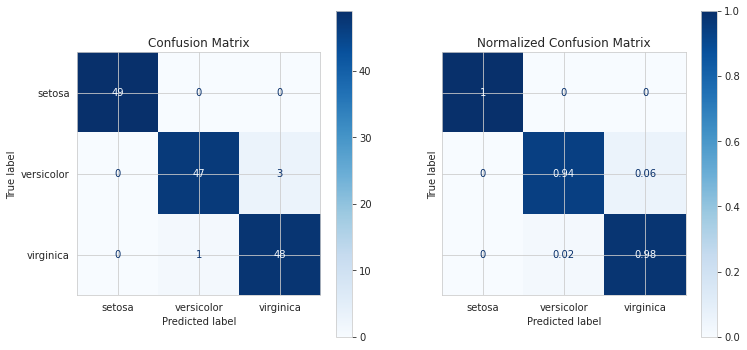

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.96,"(StandardScaler(), LogisticRegression())"


In [ ]:
def my_logistic_regression(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', LogisticRegression())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['logistic'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, clf = my_logistic_regression(results, features_data, target_data, True)
results

In [ ]:
clf['model'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
clf['model'].intercept_

array([-0.22888083,  2.07591665, -1.84703582])

The sum of the intercept_ must be 0 or close to 0.

In [ ]:
clf['model'].intercept_.sum()

1.6653345369377348e-14

In [ ]:
clf['model'].coef_

array([[-1.08053658,  1.13652426, -1.92498892, -1.80406212],
       [ 0.57816698, -0.35751966, -0.35752191, -0.81241238],
       [ 0.5023696 , -0.7790046 ,  2.28251083,  2.6164745 ]])

The column sum of the coefficients must be 0 or close to 0.

In [ ]:
coef_df = pd.DataFrame(data=clf['model'].coef_)
coef_df.loc['SUMA'] = coef_df.sum(numeric_only=True, axis=0)
coef_df

,0,1,2,3
0,-1.080537e+00,1.136524e+00,-1.924989,-1.804062
1,5.781670e-01,-3.575197e-01,-0.357522,-0.812412
2,5.023696e-01,-7.790046e-01,2.282511,2.616474
SUMA,2.220446e-16,-1.110223e-15,0.000000,0.000000


Se observan varios intercept_ y varios coef_ porque mediante el algoritmo de clasificación "One-vs-all" se crean 3 clasificadores, donde se ingresan las variables independientes y se selecciona el que mayor probabilidad retorne.

En el caso de los problemas de clasificación binaria, solo se obtendría 1 clasificador que retornaría la probabilidad de clasificación de la primera clase y la probabilidad de clasificación de la segunda clase sería (1-probabilidad_primera_clase).

<a id='variable_importancia'></a>Una variable tiene más importancia mientras mayor sea el valor absoluto de su coeficiente logístico.
Mientras más cercano sea el coeficiente logístico a 0 menos importancia tendrá la variable.

### Regularization

#### Gauss

The model has a degree of accuracy of 96.67%.


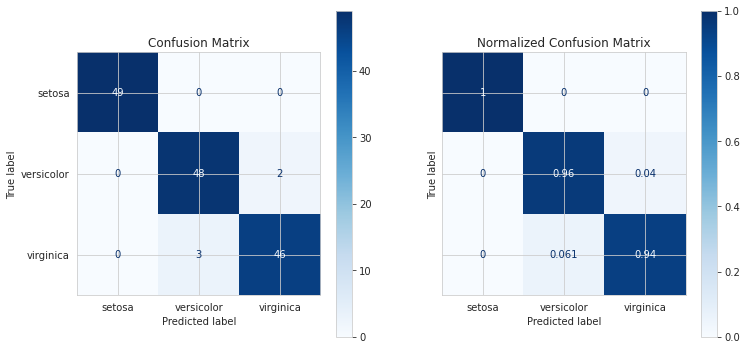

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"


In [ ]:
def my_gaussian_process_classifier(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', GaussianProcessClassifier())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['gauss'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, gauss = my_gaussian_process_classifier(results, features_data, target_data, True)
results

### Decision Trees

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
190 fits failed out of a total of 570.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
190 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages

The model has a degree of accuracy of 96.0%.


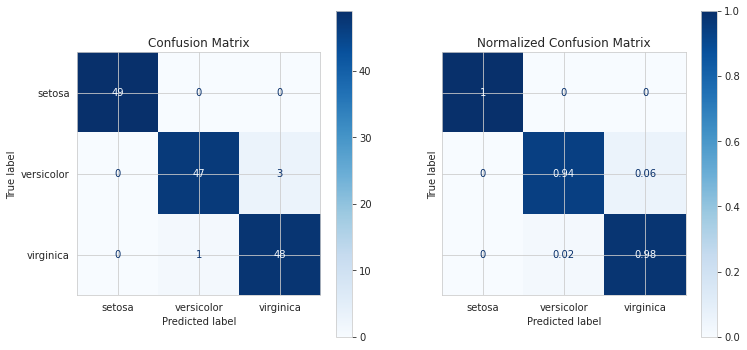

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."


In [ ]:
def my_decision_tree_classifier(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', DecisionTreeClassifier())]

    estimator, score = my_grid_search_cv(estimator=Pipeline(steps=input), X=features_data, y=target_data,
                                         param_grid={'model__criterion': ['gini', 'entropy', 'log_loss'],
                                                     'model__max_depth': range(1, 20)},
                                         show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['decision_tree'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, decision_tree_classifier = my_decision_tree_classifier(results, features_data, target_data, True)
results

Importance of the variables.

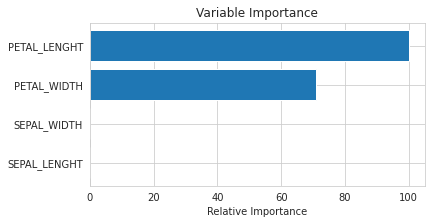

In [ ]:
def tree_feature_importances(estimator):
    feature_importances_ = estimator.feature_importances_
    feature_importances_ = 100.0 * (feature_importances_ / feature_importances_.max())
    sorted_idx = np.argsort(feature_importances_)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.rc("figure", figsize=(6, 3))
    plt.barh(pos, feature_importances_[sorted_idx], align='center')
    plt.yticks(pos, features_data.columns[sorted_idx])

    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()


tree_feature_importances(decision_tree_classifier['model'])

Representation of the tree in text.

In [ ]:
text_representation = tree.export_text(decision_tree=decision_tree_classifier['model'], feature_names=list(features_data.columns))
print(text_representation)

|--- PETAL_LENGHT <= -0.75
|   |--- class: 0.0
|--- PETAL_LENGHT >  -0.75
|   |--- PETAL_WIDTH <= 0.72
|   |   |--- PETAL_LENGHT <= 0.67
|   |   |   |--- class: 1.0
|   |   |--- PETAL_LENGHT >  0.67
|   |   |   |--- class: 2.0
|   |--- PETAL_WIDTH >  0.72
|   |   |--- PETAL_LENGHT <= 0.62
|   |   |   |--- class: 2.0
|   |   |--- PETAL_LENGHT >  0.62
|   |   |   |--- class: 2.0



In [ ]:
dot_data = tree.export_graphviz(decision_tree_classifier['model'], out_file=None, filled=True, feature_names=list(features_data.columns), rotate=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(f'{resources_prefix}_resources/tree', view=False)

'/content/drive/MyDrive/Machine Learning/Notebooks/0201_Classification - Iris Dataset Analysis/_resources/tree.png'

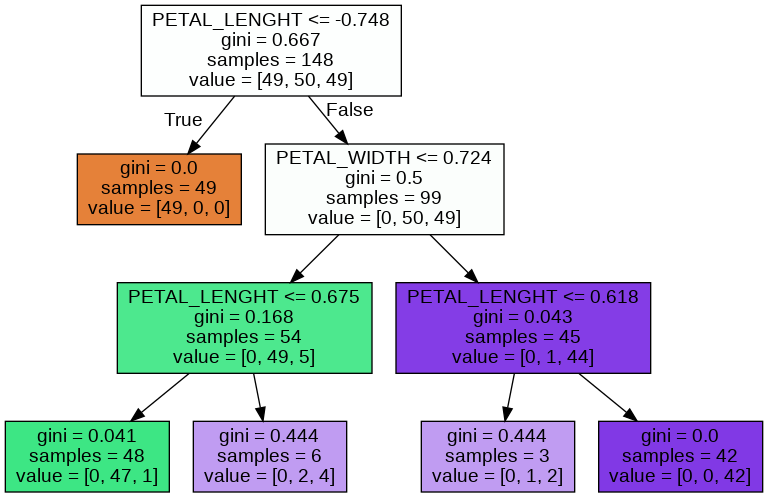

In [ ]:
Image(f'{resources_prefix}_resources/tree.png')

### Support Vector Machines (SVM)

The model has a degree of accuracy of 97.33000000000001%.


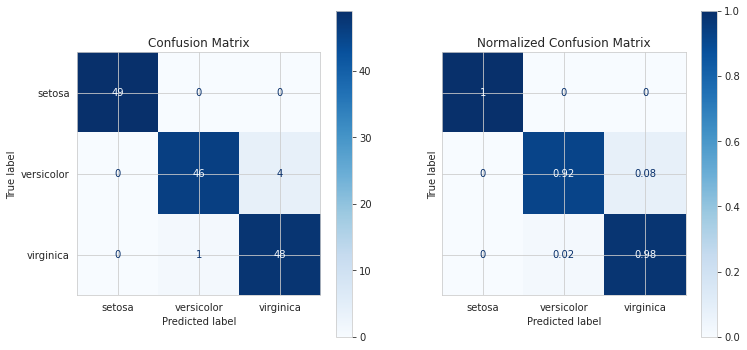

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."


In [ ]:
def my_svc(results, features_data, target_data, show_msg=False):
    param_grid = {
        # Allows transformation to higher levels.
        'model__kernel': ['linear', 'poly', 'sigmoid', 'rbf'],
        # Border complexity: linear, curved.
        'model__gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
        # Controls the tradeoff between training errors and hard margins.
        'model__C': [1, 10, 100, 1000]}

    input = [('scaler', StandardScaler()),
             ('model', SVC())]

    estimator, score = my_grid_search_cv(estimator=Pipeline(steps=input), X=features_data, y=target_data, param_grid=param_grid, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['svr'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, svc = my_svc(results, features_data, target_data, True)
results

### K Nearest Neighbors

The model has a degree of accuracy of 96.0%.


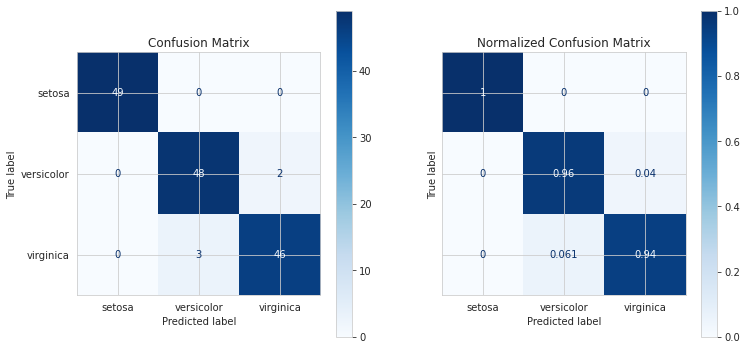

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."
4,k_nearest_neighbors,0.9600,"(StandardScaler(), KNeighborsClassifier(metric..."


In [ ]:
def my_k_neighbors_classifier(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()),
             ('model', KNeighborsClassifier())]

    estimator, score = my_grid_search_cv(estimator=Pipeline(steps=input), X=features_data, y=target_data,
                                         param_grid={'model__n_neighbors': range(3, 20, 2),
                                                     'model__metric': ['euclidean', 'manhattan', 'chebyshev']},
                                         show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['k_nearest_neighbors'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, k_neighbors_classifier = my_k_neighbors_classifier(results, features_data, target_data, True)
results

### Naive Bayes

#### Gaussian Naive Bayes

The model has a degree of accuracy of 95.33%.


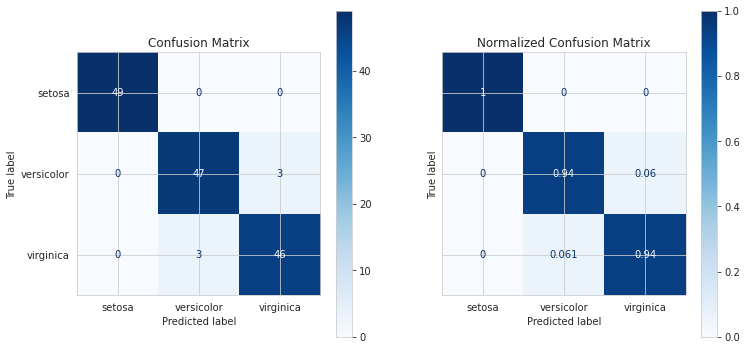

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."
4,k_nearest_neighbors,0.9600,"(StandardScaler(), KNeighborsClassifier(metric..."
5,gaussian_nb,0.9533,"(StandardScaler(), GaussianNB())"


In [ ]:
def my_gaussian_nb(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', GaussianNB())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['gaussian_nb'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, gaussian_nb = my_gaussian_nb(results, features_data, target_data, True)
results

#### Multinomial Naive Bayes

In [ ]:
# def my_multinomial_nb(results, features_data, target_data, show_msg=False):
#     input = [('scaler', StandardScaler()), ('model', MultinomialNB())]

#     estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': ['multinomial_nb'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

#     results = pd.concat([results, new_df], ignore_index=True)
#     return results, estimator


# results, multinomial_nb = my_multinomial_nb(results, features_data, target_data, True)
# results

#### Bernoulli Naive Baye

The model has a degree of accuracy of 75.81%.


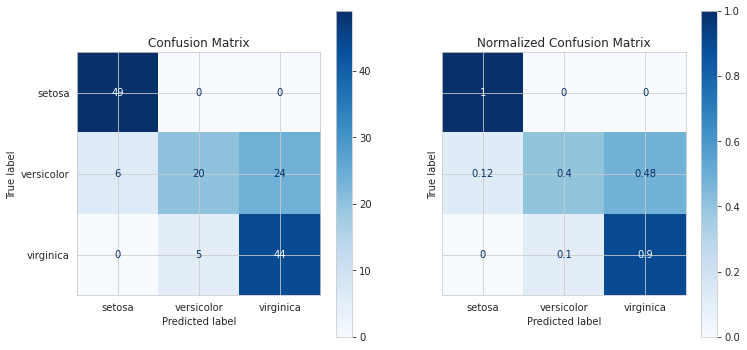

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."
4,k_nearest_neighbors,0.9600,"(StandardScaler(), KNeighborsClassifier(metric..."
5,gaussian_nb,0.9533,"(StandardScaler(), GaussianNB())"
6,bernoulli_nb,0.7581,"(StandardScaler(), BernoulliNB())"


In [ ]:
def my_bernoulli_nb(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', BernoulliNB())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['bernoulli_nb'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, bernoulli_nb = my_bernoulli_nb(results, features_data, target_data, True)
results

### Ensemble Methods

#### Bagging

The model has a degree of accuracy of 98.0%.


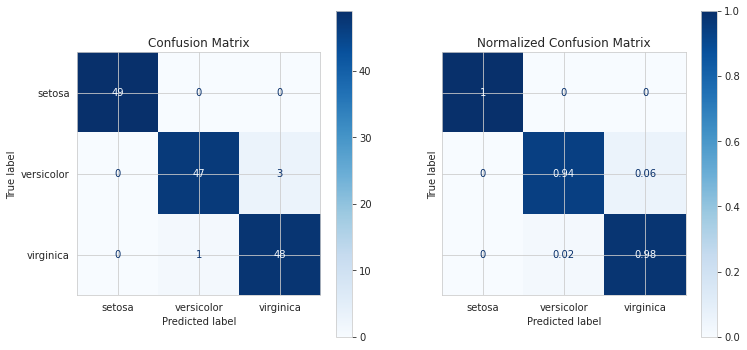

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."
4,k_nearest_neighbors,0.9600,"(StandardScaler(), KNeighborsClassifier(metric..."
5,gaussian_nb,0.9533,"(StandardScaler(), GaussianNB())"
6,bernoulli_nb,0.7581,"(StandardScaler(), BernoulliNB())"
7,bagging,0.9800,"(StandardScaler(), ((StandardScaler(), SVC(C=1..."


In [ ]:
def my_bagging_classifier(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', BaggingClassifier())]

    estimator, score = my_grid_search_cv(estimator=Pipeline(steps=input),
                                         X=features_data,
                                         y=target_data,
                                         param_grid={'model__base_estimator': [clf, gaussian_nb, decision_tree_classifier, svc, 
                                                                               k_neighbors_classifier, gaussian_nb, bernoulli_nb], 
                                                     'model__n_estimators': range(1, 21)},
                                         show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['bagging'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, bagging_classifier = my_bagging_classifier(results, features_data, target_data, True)
results

#### Boosting

The model has a degree of accuracy of 96.0%.


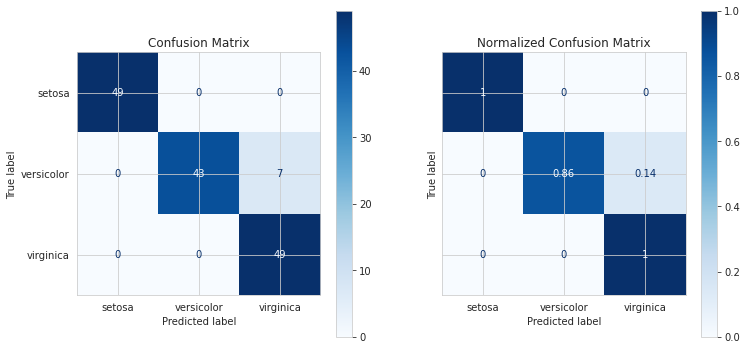

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."
4,k_nearest_neighbors,0.9600,"(StandardScaler(), KNeighborsClassifier(metric..."
5,gaussian_nb,0.9533,"(StandardScaler(), GaussianNB())"
6,bernoulli_nb,0.7581,"(StandardScaler(), BernoulliNB())"
7,bagging,0.9800,"(StandardScaler(), ((StandardScaler(), SVC(C=1..."
8,boosting,0.9600,"(StandardScaler(), (GaussianNB(), GaussianNB()..."


In [ ]:
def my_ada_boost_classifier(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', AdaBoostClassifier())]

    estimator, score = my_grid_search_cv(estimator=Pipeline(steps=input), X=features_data, y=target_data,
                                         param_grid={ 'model__base_estimator': [LogisticRegression(), DecisionTreeClassifier(), GaussianNB(), BernoulliNB()],
                                                     'model__n_estimators': range(1, 21)},
                                         show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['boosting'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, boosting_classifier = my_ada_boost_classifier(results, features_data, target_data, True)
results

#### Gradient Boosting (GBRT)

The model has a degree of accuracy of 95.33%.


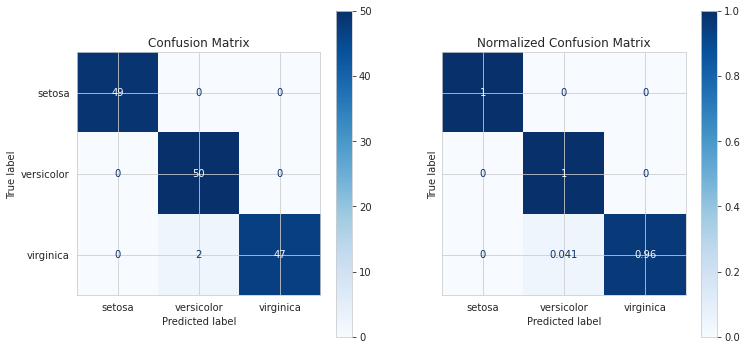

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."
4,k_nearest_neighbors,0.9600,"(StandardScaler(), KNeighborsClassifier(metric..."
5,gaussian_nb,0.9533,"(StandardScaler(), GaussianNB())"
6,bernoulli_nb,0.7581,"(StandardScaler(), BernoulliNB())"
7,bagging,0.9800,"(StandardScaler(), ((StandardScaler(), SVC(C=1..."
8,boosting,0.9600,"(StandardScaler(), (GaussianNB(), GaussianNB()..."
9,gradient_boosting,0.9533,"(StandardScaler(), ([DecisionTreeRegressor(cri..."


In [ ]:
def my_gradient_boost_classifier(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', GradientBoostingClassifier())]

    estimator, score = my_grid_search_cv(estimator=Pipeline(steps=input), X=features_data, y=target_data,
                                         param_grid={'model__n_estimators': range(1, 21)},
                                         show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['gradient_boosting'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, gradient_boosting_classifier = my_gradient_boost_classifier(results, features_data, target_data, True)
results

Importance of the variables.

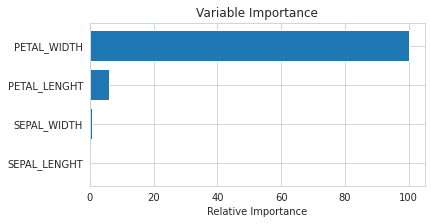

In [ ]:
tree_feature_importances(gradient_boosting_classifier['model'])

#### Random Forests

The model has a degree of accuracy of 96.67%.


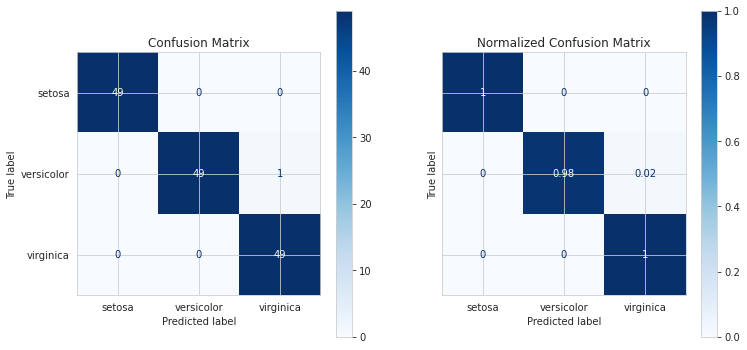

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."
4,k_nearest_neighbors,0.9600,"(StandardScaler(), KNeighborsClassifier(metric..."
5,gaussian_nb,0.9533,"(StandardScaler(), GaussianNB())"
6,bernoulli_nb,0.7581,"(StandardScaler(), BernoulliNB())"
7,bagging,0.9800,"(StandardScaler(), ((StandardScaler(), SVC(C=1..."
8,boosting,0.9600,"(StandardScaler(), (GaussianNB(), GaussianNB()..."
9,gradient_boosting,0.9533,"(StandardScaler(), ([DecisionTreeRegressor(cri..."


In [ ]:
def my_random_forest_classifier(results, features_data, target_data, show_msg=False):
    input = [('scaler', StandardScaler()), ('model', RandomForestClassifier())]

    estimator, score = my_grid_search_cv(estimator=Pipeline(steps=input), X=features_data, y=target_data,
                                         param_grid={'model__n_estimators': range(1, 21)},
                                         show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['random_forest'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, random_forest_classifier = my_random_forest_classifier(results, features_data, target_data, True)
results

Importance of the variables.

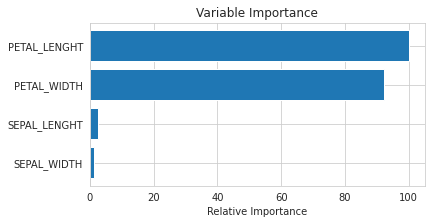

In [ ]:
tree_feature_importances(random_forest_classifier['model'])

### Polynomial Classifier

In [ ]:
# def my_polynomial_classifier(results, features_data, target_data, degree, show_msg=False):
#     # LogisticRegression ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', LogisticRegression())]

#     clf_polynomial, score = my_cross_validate(estimator=Pipeline(steps=input),
#                                               X=features_data, y=target_data, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'logistic_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [clf_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # Gauss ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', GaussianProcessClassifier())]

#     gauss_polynomial, score = my_cross_validate(estimator=Pipeline(steps=input),
#                                                 X=features_data, y=target_data, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'gauss_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [gauss_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # Decision trees ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', DecisionTreeClassifier())]

#     # For hyperparameters to work, '__' must be placed between the input name and the hyperparameter name.
#     param_grid = {'model__max_depth': range(1, 20)}

#     decision_tree_classifier_polynomial, score = my_grid_search_cv(estimator=Pipeline(steps=input),
#                                                                    X=features_data, y=target_data,
#                                                                    param_grid=param_grid, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'decision_tree_classifier_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [decision_tree_classifier_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # Bagging ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', BaggingClassifier())]

#     # For hyperparameters to work, '__' must be placed between the input name and the hyperparameter name.
#     param_grid = {'model__n_estimators': range(1, 21)}

#     bagging_classifier_polynomial, score = my_grid_search_cv(estimator=Pipeline(steps=input),
#                                                              X=features_data, y=target_data,
#                                                              param_grid=param_grid, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'bagging_classifier_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [bagging_classifier_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # Boosting ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', AdaBoostClassifier())]

#     # For hyperparameters to work, '__' must be placed between the input name and the hyperparameter name.
#     param_grid = {'model__n_estimators': range(1, 21)}

#     ada_boost_classifier_polynomial, score = my_grid_search_cv(estimator=Pipeline(steps=input),
#                                                                X=features_data, y=target_data,
#                                                                param_grid=param_grid, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'ada_boost_classifier_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [ada_boost_classifier_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # Gradient Boosting (GBRT) ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', GradientBoostingClassifier())]

#     # For hyperparameters to work, '__' must be placed between the input name and the hyperparameter name.
#     param_grid = {'model__n_estimators': range(1, 21)}

#     gradient_boosting_classifier_polynomial, score = my_grid_search_cv(estimator=Pipeline(steps=input),
#                                                                        X=features_data, y=target_data,
#                                                                        param_grid=param_grid, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'gradient_boosting_classifier_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [gradient_boosting_classifier_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # Random forests ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', RandomForestClassifier())]

#     # For hyperparameters to work, '__' must be placed between the input name and the hyperparameter name.
#     param_grid = {'model__n_estimators': range(1, 21)}

#     random_forest_classifier_polynomial, score = my_grid_search_cv(estimator=Pipeline(steps=input),
#                                                                    X=features_data, y=target_data,
#                                                                    param_grid=param_grid, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'random_forest_classifier_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [random_forest_classifier_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # Support Vector Machines (SVC) ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', SVC())]

#     # For hyperparameters to work, '__' must be placed between the input name and the hyperparameter name.
#     param_grid = {
#         # Allows transformation to higher levels.
#         'model__kernel': ['linear', 'poly', 'sigmoid', 'rbf'],
#         # Border complexity: linear, curved.
#         'model__gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
#         # Controls the tradeoff between training errors and hard margins.
#         'model__C': [1, 10, 100, 1000]}

#     svc_polynomial, score = my_grid_search_cv(estimator=Pipeline(steps=input),
#                                               X=features_data, y=target_data,
#                                               param_grid=param_grid, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'svc_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [svc_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # K Nearest Neighbors ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', KNeighborsClassifier())]

#     # For hyperparameters to work, '__' must be placed between the input name and the hyperparameter name.
#     param_grid = {'model__n_neighbors': range(3, 20, 2),
#                   'model__metric': ['euclidean', 'manhattan', 'chebyshev']}

#     k_neighbors_classifier_polynomial, score = my_grid_search_cv(estimator=Pipeline(steps=input),
#                                                                  X=features_data, y=target_data,
#                                                                  param_grid=param_grid, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'k_neighbors_classifier_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [k_neighbors_classifier_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     # Gaussian Naive Bayes  ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', GaussianNB())]

#     gaussian_polynomial, score = my_cross_validate(estimator=Pipeline(steps=input),
#                                                    X=features_data, y=target_data, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'gaussian_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [gaussian_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

# #     # Multinomial Naive Bayes  ######################
# #     input = [('scaler', StandardScaler()),
# #              ('polynomial', PolynomialFeatures(degree=degree)),
# #              ('model', MultinomialNB())]

# #     multinomial_polynomial, score = my_cross_validate(estimator=Pipeline(steps=input),
# #                                                       X=features_data, y=target_data, show_msg=show_msg)

# #     new_df = pd.DataFrame(data={'MODEL': [f'multinomial_polynomial_{degree}'],
# #                                 'ACCURACY': [score],
# #                                 'ESTIMATOR': [multinomial_polynomial]})

# #     results = pd.concat([results, new_df], ignore_index=True)

#     # Bernoulli Naive Bayes  ######################
#     input = [('scaler', StandardScaler()),
#              ('polynomial', PolynomialFeatures(degree=degree)),
#              ('model', BernoulliNB())]

#     bernoulli_polynomial, score = my_cross_validate(estimator=Pipeline(steps=input),
#                                                     X=features_data, y=target_data, show_msg=show_msg)

#     new_df = pd.DataFrame(data={'MODEL': [f'bernoulli_polynomial_{degree}'],
#                                 'ACCURACY': [score],
#                                 'ESTIMATOR': [bernoulli_polynomial]})

#     results = pd.concat([results, new_df], ignore_index=True)

#     #
#     #
#     #
#     return results


# # If you are trying to generate a complex model, you can add other degrees to the polynomial (3).
# for i in [2]:
#     results = my_polynomial_classifier(results, features_data, target_data,
#                                        i, True)

# results

### Learning curves

Regarding the loss function, since it is a regression problem we can use the Mean Square Error (MSE). In scikit-learn the MSE can be used in all cases where the `scoring` parameter can be used, and it is called `neg_mean_absolute_error`. It is provided by default with a negative sign.

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(clf, features_data, target_data, cv=5, n_jobs=-1, scoring='accuracy', 
                                                        train_sizes=np.linspace(0.01, 1., 10))

The `learning_curve` function returns 3 arrays, one with the different sizes of the dataset that have been evaluated, another with the training score and another with the score of the cross-validation data (we have used 5 validations when specifying `cv=5` , therefore for each value of train_sizes we will get 5 test and train scores.

In [ ]:
train_sizes

array([  1,  14,  27,  40,  53,  66,  79,  92, 105, 118])

In [ ]:
train_scores

array([[       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [1.        , 1.        , 1.        , 1.        ,        nan],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.98913043, 0.98913043, 0.98913043, 0.98913043, 0.98913043],
       [0.96190476, 0.97142857, 0.98095238, 0.98095238, 0.98095238],
       [0.94915254, 0.96610169, 0.97457627, 0.98305085, 0.95762712]])

In [ ]:
test_scores

array([[       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [0.66666667, 0.5       , 0.63333333, 0.5862069 ,        nan],
       [0.66666667, 0.66666667, 0.66666667, 0.68965517, 0.65517241],
       [0.66666667, 0.66666667, 0.66666667, 0.68965517, 0.65517241],
       [0.66666667, 0.66666667, 0.66666667, 0.68965517, 0.65517241],
       [0.96666667, 0.93333333, 0.86666667, 0.89655172, 0.96551724],
       [0.96666667, 0.96666667, 1.        , 0.93103448, 1.        ],
       [0.96666667, 1.        , 0.93333333, 0.89655172, 1.        ]])

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean

array([       nan,        nan,        nan,        nan, 1.        ,
       1.        , 1.        , 0.98913043, 0.9752381 , 0.96610169])

In [ ]:
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean

array([       nan,        nan,        nan,        nan, 0.66896552,
       0.66896552, 0.66896552, 0.92574713, 0.97287356, 0.95931034])

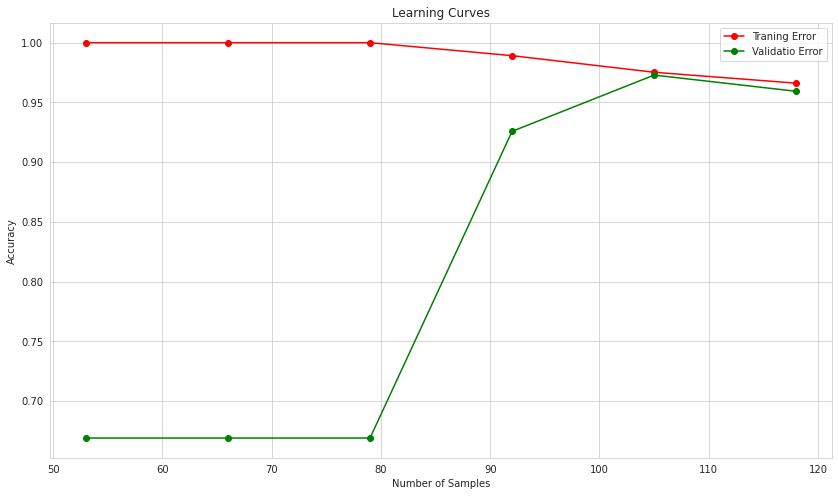

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.rc('figure', figsize=(14, 8))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Traning Error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validatio Error')

plt.title('Learning Curves')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.legend()

When using (Accuracy) both the training and validation data should converge. The closer to 0 they converge, the better (less prediction error will exist).

If the MSE values do not vary at some point, it means that no matter how much data is added to the model, we will not obtain better results.

Shortcode for all estimators.

In [ ]:
results_model_key = results.copy()
results_model_key.set_index('MODEL', inplace=True)


@interact(df=fixed(results_model_key.copy()), model=results_model_key.index)
def _(df, model):
    plt.rc("figure", figsize=(14, 8))

    train_sizes, train_scores, test_scores = learning_curve(df.loc[model].ESTIMATOR, features_data, target_data, cv=5, n_jobs=-1,
                                                            train_sizes=np.linspace(0.01, 1., 10),
                                                            scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # train_scores_mean y test_scores_mean se colocan con el signo - para convertirlos en +
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Traning error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validatio error")

    plt.title(f'Learning Curves: {model}')
    plt.xlabel('Number of Samples')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='model', options=('logistic', 'gauss', 'decision_tree', 'svr', 'k_n…

### Validation curves

In [ ]:
trees = [2, 10, 20, 50, 100, 150, 200]

train_scores, test_scores = validation_curve(random_forest_classifier['model'], features_data, target_data, param_name="n_estimators", 
                                             param_range=trees, cv=5, scoring="accuracy", n_jobs=-1)

Similar to `learning_curve`, `validation_curve` returns the training and test scores for each value in the range, and within each value, for each iteration of the cross-validation (defined as `cv=5`, so we are doing 10 different validations).

We calculate the mean scores and make the graphs.

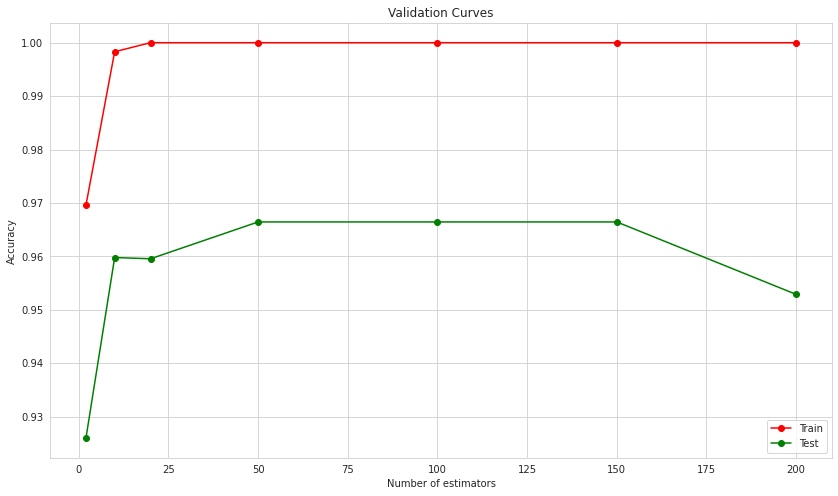

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.rc("figure", figsize=(14, 8))
plt.plot(trees, train_scores_mean, 'o-', color="r", label="Train")
plt.plot(trees, test_scores_mean, 'o-', color="g", label="Test")
plt.title("Validation Curves")

plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.legend()

When creating each estimator an optimization of its parameters is performed, so `validation_curve` is not needed, it has only been added for educational purposes.

### Resume

In [ ]:
results_sort = results.sort_values(by=['ACCURACY'], ascending=[False])
results_sort

,MODEL,ACCURACY,ESTIMATOR
7,bagging,0.9800,"(StandardScaler(), ((StandardScaler(), SVC(C=1..."
3,svr,0.9733,"(StandardScaler(), SVC(C=1, gamma=0.0001, kern..."
1,gauss,0.9667,"(StandardScaler(), GaussianProcessClassifier())"
10,random_forest,0.9667,"(StandardScaler(), (DecisionTreeClassifier(max..."
0,logistic,0.9600,"(StandardScaler(), LogisticRegression())"
2,decision_tree,0.9600,"(StandardScaler(), DecisionTreeClassifier(max_..."
4,k_nearest_neighbors,0.9600,"(StandardScaler(), KNeighborsClassifier(metric..."
8,boosting,0.9600,"(StandardScaler(), (GaussianNB(), GaussianNB()..."
5,gaussian_nb,0.9533,"(StandardScaler(), GaussianNB())"
9,gradient_boosting,0.9533,"(StandardScaler(), ([DecisionTreeRegressor(cri..."


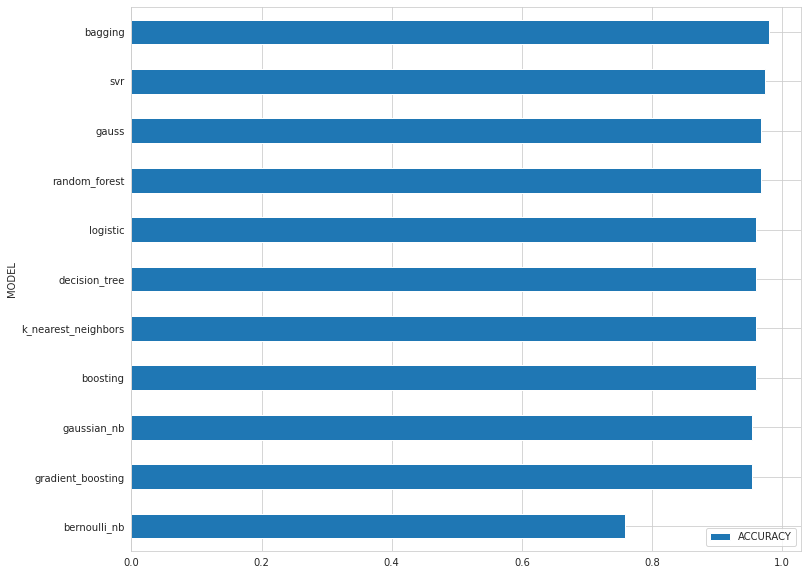

In [ ]:
plt.rc("figure", figsize=(12, 10))
results_sort[::-1].set_index('MODEL').plot.barh(rot=0)

In [ ]:
print(
    f'Best tentative algorithm "{results_sort.iloc[0].MODEL}" with ACCURACY={results_sort.iloc[0].ACCURACY}".')

Best tentative algorithm "bagging" with ACCURACY=0.98".


### Export

In [ ]:
best_estimator = results_sort.iloc[0].ESTIMATOR

Save to file.

In [ ]:
pkl_filename = f'{resources_prefix}_resources/best_estimator.pkl'

with open(pkl_filename, 'wb') as file:
    pickle.dump(best_estimator, file)

Load from file.

In [ ]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [ ]:
pickle_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 BaggingClassifier(base_estimator=Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('model',
                                                                   SVC(C=1,
                                                                       gamma=0.0001,
                                                                       kernel='linear'))]),
                                   n_estimators=8))])

## Deep Learning

Cuda version.

In [ ]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Cuda version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")

Tensorflow version: 2.8.2
Cuda version: 11.1
Cudnn version: 8


**Enable GPU**

- The environment must be created with a version of Python compatible with the operation of Tensorflow and its use of the GPU (https://www.tensorflow.org/install/pip#virtual-environment-install).
- Before installing tensorflow-gpu you must install CUDA Toolkit and cuDNN from official NVIDIA site.
- Anaconda must be restarted after installing tensorflow-gpu.

In [ ]:
# !conda install -y tensorflow-gpu keras-gpu

In [ ]:
if len(tf.config.list_physical_devices('GPU')) == 0:
    raise SystemExit("Restart Anaconda to activate the GPU.")
else:
    print('GPU activated.')

GPU activated.


Available hardware.

In [ ]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available hardware details.

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14507907845731043418
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15596808953618529286
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

### Data Scaler

Data for neural networks is mostly normalized data, not standardized.

In [ ]:
features_data.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
# Se pueden estandarizar (StandardScaler) o escalar (MinMaxScaler), probar ambas propuestas.
features_data_scaled = StandardScaler().fit_transform(features_data)
# features_data_scaled = MinMaxScaler().fit_transform(features_data)

# Convert to a dataframe
features_data_scaled = pd.DataFrame(data=features_data_scaled, columns=features_column)

features_data_scaled.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH
0,-0.896274,1.064477,-1.344793,-1.316134
1,-1.137015,-0.120054,-1.344793,-1.316134
2,-1.377757,0.353759,-1.401675,-1.316134
3,-1.498127,0.116852,-1.287911,-1.316134
4,-1.016645,1.301383,-1.344793,-1.316134


### Keras

In [ ]:
# mlp => Multilayer Perceptron (MLP)

keras_net_type = 'mlp'

Training and test data are generated.

In [ ]:
categorical_target_data = np_utils.to_categorical(target_data)
categorical_target_data[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_data_scaled, categorical_target_data, test_size=0.2)

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001, restore_best_weights=True)

In [ ]:
keras_file_path = f'{resources_prefix}_resources/keras.hdf5'
checkpoint = ModelCheckpoint(filepath=keras_file_path, verbose=1, save_weights_only=True, save_freq='epoch')

In [ ]:
if keras_net_type == 'mlp':
    with tf.device("/GPU:0"):
        # clasificación binaria: activation sigmoid en la ultima capa y binary_crossentropy como loss.
        # clasificación multiclase: activation softmax en la ultima capa y categorical_crossentropy como loss.

        keras_model = Sequential([Dense(units=10, activation='relu', kernel_constraint=maxnorm(max_value=3), input_dim=X_train.shape[1]),
                                  Dropout(rate=0.2),

                                  Dense(units=10, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                  Dropout(rate=0.2),

                                  Dense(units=3, activation='softmax')])

    #   https://fmorenovr.medium.com/sparse-categorical-cross-entropy-vs-categorical-cross-entropy-ea01d0392d28

        epochs = 100
        lr = 0.01
        decay = lr/epochs

        keras_model.compile(optimizer=Adam(learning_rate=lr, decay=decay),       # optimizer
                            loss='categorical_crossentropy',          # función de pérdida o coste
                            metrics=['accuracy'])                     # Metrics to observe the evolution of the model training

        try:
            keras_model.load_weights(filepath=keras_file_path)
            print('Weights loaded!\n')
        except:
            print('Weights unloaded!\n')

        display(keras_model.summary())

        # Se debe ajustar el modelo dentro del ámbito, sino se ejecutará en dependencia si se activó o no la GPU
        historial_train = keras_model.fit(X_train, y_train, batch_size=100, epochs=epochs, verbose=1, validation_data=(X_test, y_test), callbacks=[checkpoint])

Weights unloaded!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/100
1/2 [==============>...............] - ETA: 3s - loss: 1.2501 - accuracy: 0.2500
Epoch 1: saving model to /content/drive/MyDrive/Machine Learning/Notebooks/0201_Classification - Iris Dataset Analysis/_resources/keras.hdf5
2/2 [==============================] - 4s 200ms/step - loss: 1.2520 - accuracy: 0.2542 - val_loss: 1.0571 - val_accuracy: 0.4000
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 1.1091 - accuracy: 0.4100
Epoch 2: saving model to /content/drive/MyDrive/Machine Learning/Notebooks/0201_Classification - Iris Dataset Analysis/_resources/keras.hdf5
2/2 [==============================] - 0s 48ms/step - loss: 1.0794 - accuracy: 0.4407 - val_loss: 0.9679 - val_accuracy: 0.5667
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.8764 - accuracy: 0.5500
Epoch 3: saving model to /content/drive/MyDrive/Machine Learning/Notebooks/0201_Classification - Iris Dataset Analysis/_resources/keras.hdf5
2/2 [==============================] - 0s

In [ ]:
hist = pd.DataFrame(historial_train.history)
hist['epoch'] = historial_train.epoch
hist.tail(10)

,loss,accuracy,val_loss,val_accuracy,epoch
90,0.138280,0.966102,0.112247,0.966667,90
91,0.140355,0.949153,0.109488,0.966667,91
92,0.174085,0.915254,0.107365,0.966667,92
93,0.151626,0.949153,0.106513,0.966667,93
94,0.154459,0.932203,0.106683,0.966667,94
95,0.126978,0.949153,0.108675,0.966667,95
96,0.168201,0.923729,0.109718,0.966667,96
97,0.114225,0.957627,0.107036,0.966667,97
98,0.132136,0.940678,0.104385,0.966667,98
99,0.130156,0.940678,0.104398,0.966667,99


Metrics.

In [ ]:
keras_model.metrics_names

['loss', 'accuracy']

Predict.

In [ ]:
keras_model.predict([X_test[:10]])

array([[5.8639969e-08, 2.1400360e-02, 9.7859955e-01],
       [2.3738263e-02, 9.7353935e-01, 2.7223828e-03],
       [2.3147630e-08, 1.5986221e-02, 9.8401374e-01],
       [1.7072778e-06, 8.5330814e-02, 9.1466755e-01],
       [1.0000000e+00, 5.6594551e-08, 5.5995630e-19],
       [1.3286336e-06, 5.3086665e-02, 9.4691199e-01],
       [4.3535761e-06, 6.7398824e-02, 9.3259686e-01],
       [3.0833025e-06, 6.4332806e-02, 9.3566412e-01],
       [1.0000000e+00, 3.3471657e-09, 2.4415108e-21],
       [2.9793954e-08, 2.0504516e-02, 9.7949547e-01]], dtype=float32)

In [ ]:
np.argmax(keras_model.predict([X_test[:10]]), axis=1)

array([2, 1, 2, 2, 0, 2, 2, 2, 0, 2])

Analyzing the training and evaluation data.

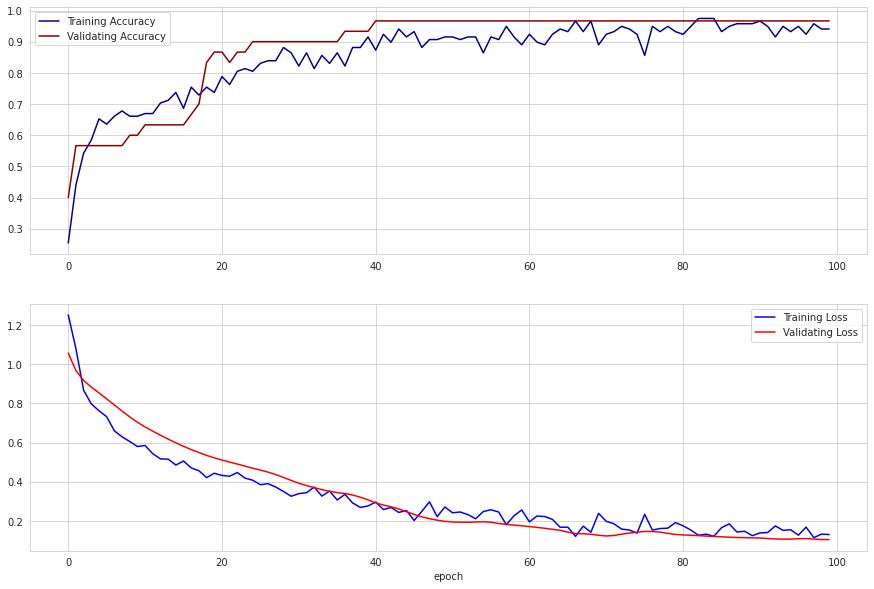

In [ ]:
def plot_metrics(historial_train):
    plt.figure(figsize=(15, 10))

    acc = historial_train.history['accuracy']
    val_acc = historial_train.history['val_accuracy']
    loss = historial_train.history['loss']
    val_loss = historial_train.history['val_loss']

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(acc, color='darkblue', label='Training Accuracy')
    ax1.plot(val_acc, color='darkred', label='Validating Accuracy')
    ax1.legend()

    ax1 = plt.subplot(2, 1, 2)
    ax1.set_xlabel('epoch')
    ax1.plot(loss, color='blue', label='Training Loss')
    ax1.plot(val_loss, color='red', label='Validating Loss')
    ax1.legend()


plot_metrics(historial_train)

Model evaluation.

In [ ]:
loss_train, accuracy_train = keras_model.evaluate(X_train, y_train)
loss_test, accuracy_test = keras_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 23ms/step - loss: 0.1044 - accuracy: 0.9667


#### Export

Save to file.

In [ ]:
h5_filename = f'{resources_prefix}_resources/keras_model.h5'
keras_model.save(h5_filename)

Load from file.

In [ ]:
keras_model = load_model(h5_filename)
keras_model